# Necessary Steps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U ultralytics

In [ ]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import shutil
from random import choice
import re
import csv
import pandas as pd
import glob
import math
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Polygon

from ultralytics import YOLO
from PIL import Image


In [ ]:
cd /content/drive/MyDrive/Ponds_Wells_Plantations_Detection/Ponds

/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17


In [ ]:
pwd = os.getcwd()
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

# Get Data from Roboflow

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

In [ ]:
"""
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KNV14d79vuacfXy69y4s")
project = rf.workspace("ahi-7tpvv").project("pondsegmentation")
version = project.version(5)
dataset = version.download("yolov11")
"""

'\n!pip install roboflow\n\nfrom roboflow import Roboflow\nrf = Roboflow(api_key="KNV14d79vuacfXy69y4s")\nproject = rf.workspace("ahi-7tpvv").project("pondsegmentation")\nversion = project.version(5)\ndataset = version.download("yolov11")\n'

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xi0GmSwVPwJmrIJu9U9m")
project = rf.workspace("pond-p90hl").project("pondshardmine")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...


# Visualize

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

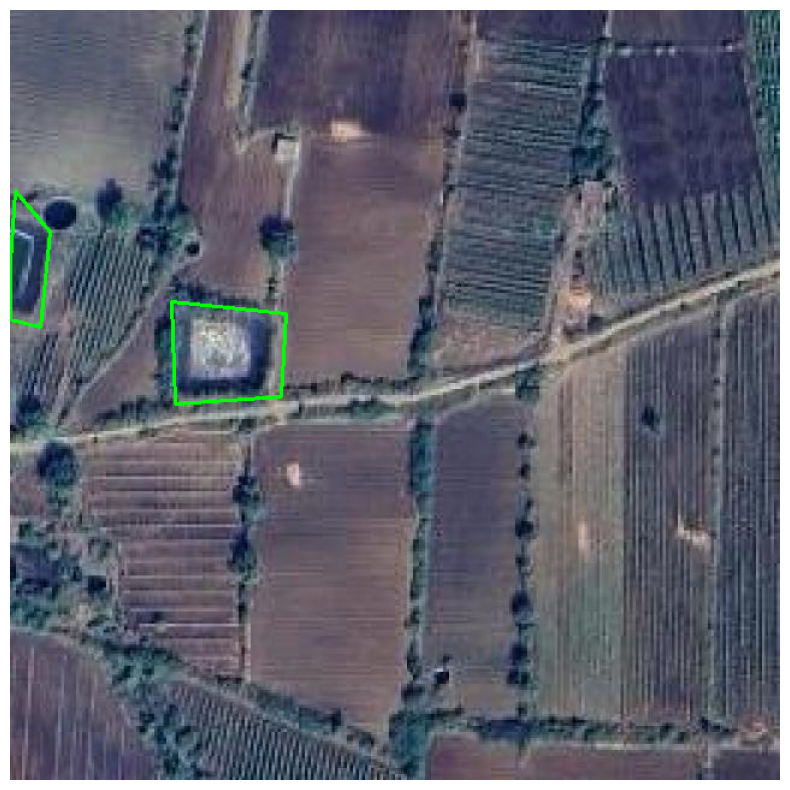

In [ ]:
annotation_file_path = "training_data/train/labels/tile_Vashim__20-21727791_77-30298027999993_0_17_93681_58017_png.rf.fc1115b68a3312475bac62528cca4c6a.txt"
annotation_file_path = os.path.join(pwd, annotation_file_path)
image_file_path = "training_data/train/images/tile_Vashim__20-21727791_77-30298027999993_0_17_93681_58017_png.rf.fc1115b68a3312475bac62528cca4c6a.jpg"
image_file_path = os.path.join(pwd, image_file_path)

# Check if the files exist
if not os.path.exists(image_file_path):
    raise FileNotFoundError(f"Image file not found: {image_file_path}")
if not os.path.exists(annotation_file_path):
    raise FileNotFoundError(f"Annotation file not found: {annotation_file_path}")

# Read the image
image = cv2.imread(image_file_path)
if image is None:
    raise ValueError(f"Failed to read image from file: {image_file_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get the image dimensions
image_height, image_width = image.shape[:2]

# Read the annotation file
with open(annotation_file_path, 'r') as f:
    annotations = f.readlines()

# Define a function to draw polygons on the image
def draw_polygons(image, annotations, img_width, img_height):
    for annotation in annotations:
        parts = annotation.strip().split()
        class_index = int(parts[0])
        points = list(map(float, parts[1:]))
        # Scale the normalized coordinates to the image dimensions
        scaled_points = [int(points[i] * img_width if i % 2 == 0 else points[i] * img_height) for i in range(len(points))]
        # Create a list of (x, y) tuples
        polygon = [(scaled_points[i], scaled_points[i+1]) for i in range(0, len(scaled_points), 2)]
        polygon = np.array(polygon, np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        # Draw the polygon on the image
        cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
    return image

# Draw the annotations on the image
image_with_annotations = draw_polygons(image, annotations, image_width, image_height)

# Display the image with annotations
plt.figure(figsize=(10, 10))
plt.imshow(image_with_annotations)
plt.axis('off')
plt.show()

In [ ]:
"""data_train_images = os.path.join(pwd, "data/train/images")
data_train_labels = os.path.join(pwd, "data/train/labels")
data_val_images = os.path.join(pwd, "data/val/images")
data_val_labels = os.path.join(pwd, "data/val/labels")"""


'data_train_images = os.path.join(pwd, "data/train/images")\ndata_train_labels = os.path.join(pwd, "data/train/labels")\ndata_val_images = os.path.join(pwd, "data/val/images")\ndata_val_labels = os.path.join(pwd, "data/val/labels")'

# Model Training

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

In [ ]:
# Load a model
# model = YOLO("yolo11x-seg.yaml")  # build a new model from YAML
# model = YOLO("yolo11x-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11x-seg.yaml").load("yolo11x.pt")  # build from YAML and transfer weights

Transferred 1015/1077 items from pretrained weights


In [ ]:

# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'2'

In [ ]:
#Define a project --> Destination directory for all results
project = "FarmPonds_results"
#Define subdirectory for this specific training
name = "100epochs_noAlbumentations" #note that if you run the training again, it creates a directory: 200_epochs-2

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
# Train the model
results = model.train(data= os.path.join(pwd, "data.yaml"),
                      project=project,
                      name=name,
                      epochs=100,
                      patience= 0, #patience=0 to disable early stopping.
                      batch=2,
                      imgsz=256,
                      augment=False
                      )

Ultralytics 8.3.19 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolo11x-seg.yaml, data=/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17/data.yaml, epochs=100, time=None, patience=0, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=FarmPonds_results, name=HardMine_100epochs_noAlbumentations, exist_ok=False, pretrained=yolo11x.pt, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=

100%|██████████| 755k/755k [00:00<00:00, 4.70MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17/data/train/labels.cache... 823 images, 5 backgrounds, 0 corrupt: 100%|██████████| 823/823 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17/data/val/labels.cache... 77 images, 1 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<?, ?it/s]


Plotting labels to FarmPonds_results/HardMine_100epochs_noAlbumentations/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 176 weight(decay=0.0), 187 weight(decay=0.0005), 186 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to FarmPonds_results/HardMine_100epochs_noAlbumentations
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.49G       1.94      3.113       2.26      1.514          0        256: 100%|██████████| 412/412 [01:13<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

                   all         77        117    0.00647     0.0962    0.00254    0.00102    0.00489     0.0769    0.00179   0.000536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.96G      2.209      3.092      2.446      1.671          5        256: 100%|██████████| 412/412 [01:03<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.45it/s]

                   all         77        117       0.23      0.327        0.2     0.0872       0.23      0.327      0.199     0.0888



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.97G      2.187      2.857      2.402      1.625          1        256: 100%|██████████| 412/412 [01:01<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.28it/s]

                   all         77        117      0.873      0.282      0.346      0.152      0.866      0.276      0.336      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.98G      2.152      2.876       2.34       1.61          2        256: 100%|██████████| 412/412 [01:01<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.49it/s]

                   all         77        117      0.343      0.391      0.384       0.17       0.77      0.327      0.386      0.158



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.97G      1.956      2.663      2.021      1.502          1        256: 100%|██████████| 412/412 [01:02<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.81it/s]

                   all         77        117      0.641      0.449      0.476      0.198      0.648      0.462      0.484      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.96G      1.953       2.58       1.99      1.498          0        256: 100%|██████████| 412/412 [01:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]

                   all         77        117      0.778      0.494      0.586      0.313      0.758      0.487      0.579      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.97G       1.89      2.565      1.925      1.482          3        256: 100%|██████████| 412/412 [01:02<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.25it/s]

                   all         77        117      0.636      0.506      0.575      0.302      0.603      0.551       0.58      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.97G      1.899      2.529      1.808      1.443          0        256: 100%|██████████| 412/412 [01:01<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.11it/s]

                   all         77        117      0.736      0.603      0.663      0.357      0.742      0.595      0.657      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.96G      1.891      2.461      1.758       1.45          2        256: 100%|██████████| 412/412 [01:02<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.87it/s]

                   all         77        117      0.647      0.561      0.606      0.315      0.641      0.555      0.595      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.96G      1.837      2.405      1.719      1.437          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.89it/s]

                   all         77        117      0.682      0.513      0.599      0.324      0.683      0.506      0.586      0.307



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.97G      1.795      2.394      1.708      1.392          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.02it/s]

                   all         77        117      0.626      0.533      0.611      0.322      0.602      0.552      0.606      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.96G      1.849      2.396      1.691       1.44          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.00it/s]

                   all         77        117      0.803      0.559       0.69       0.39      0.798      0.567      0.677      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.97G       1.75      2.281      1.655      1.375          3        256: 100%|██████████| 412/412 [01:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.79it/s]

                   all         77        117      0.748      0.542      0.627      0.362      0.748      0.542      0.623       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.97G      1.789      2.296      1.676      1.386          1        256: 100%|██████████| 412/412 [01:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.45it/s]

                   all         77        117      0.621      0.558      0.626      0.371      0.639      0.564      0.641      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.95G      1.797      2.268      1.616      1.405          0        256: 100%|██████████| 412/412 [00:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]

                   all         77        117      0.741      0.647      0.683      0.372      0.721      0.628      0.659      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.97G      1.777      2.327      1.658      1.384          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.77it/s]

                   all         77        117      0.722      0.581      0.664      0.389      0.718       0.57      0.654      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.96G      1.709      2.193      1.619      1.347          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.91it/s]

                   all         77        117       0.62       0.63      0.638      0.368      0.632      0.628      0.632      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.96G      1.685      2.262      1.525      1.343          3        256: 100%|██████████| 412/412 [01:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.28it/s]

                   all         77        117       0.65       0.59      0.651      0.363      0.648      0.565      0.633      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.97G      1.694      2.194      1.524      1.348          4        256: 100%|██████████| 412/412 [00:59<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.62it/s]

                   all         77        117      0.728       0.59      0.645      0.371      0.728       0.59      0.642      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.96G      1.689       2.19       1.53       1.34          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.60it/s]

                   all         77        117      0.755      0.582       0.66      0.381      0.749      0.574      0.652       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.98G      1.713      2.232      1.556      1.348          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.37it/s]

                   all         77        117        0.7        0.6      0.679      0.403      0.702      0.583      0.667      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.96G      1.678      2.137      1.455      1.345          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.05it/s]

                   all         77        117       0.63      0.703      0.706      0.396      0.625      0.697      0.696      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.96G      1.677      2.218      1.459      1.324          6        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.09it/s]

                   all         77        117      0.635      0.744      0.711      0.413      0.635      0.744       0.71      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.96G      1.649      2.196      1.421      1.331          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.79it/s]

                   all         77        117      0.784      0.548      0.679      0.367      0.777      0.541      0.669      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.97G      1.685      2.146      1.381      1.349          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.64it/s]

                   all         77        117      0.708       0.59       0.64      0.388      0.699      0.583      0.634      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.97G      1.646      2.118      1.511      1.324          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.60it/s]

                   all         77        117      0.637      0.628      0.639      0.384      0.631      0.622      0.625      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.96G      1.618      2.125      1.369      1.296          6        256: 100%|██████████| 412/412 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.23it/s]

                   all         77        117      0.694       0.59      0.654      0.398      0.694       0.59      0.646      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.97G      1.644      2.094        1.4      1.329          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.07it/s]

                   all         77        117      0.608      0.612      0.633      0.379      0.596      0.596      0.616      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.97G      1.621      2.089      1.335      1.312          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.74it/s]

                   all         77        117      0.658      0.686      0.704      0.424      0.644      0.673      0.691      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.96G      1.618      2.082       1.31      1.312          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.30it/s]

                   all         77        117      0.712      0.673      0.694      0.394      0.712      0.673      0.682      0.368



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.96G      1.621      2.117      1.342      1.336          3        256: 100%|██████████| 412/412 [00:58<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.37it/s]

                   all         77        117      0.674      0.609      0.671      0.426      0.677      0.609      0.659      0.386



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.96G      1.571      2.035      1.351      1.297          1        256: 100%|██████████| 412/412 [00:57<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.16it/s]

                   all         77        117      0.718      0.636      0.716      0.409      0.711       0.63      0.697      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.98G      1.572      1.986      1.315      1.267          4        256: 100%|██████████| 412/412 [00:57<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.76it/s]

                   all         77        117      0.718      0.687      0.698      0.416       0.72      0.686      0.687      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.97G      1.601      2.035      1.314      1.288          2        256: 100%|██████████| 412/412 [00:56<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.71it/s]

                   all         77        117      0.665      0.715      0.723      0.449      0.665      0.715      0.717      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.96G      1.611      2.058      1.328      1.301          4        256: 100%|██████████| 412/412 [01:01<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.64it/s]

                   all         77        117      0.733      0.668      0.704      0.414      0.728      0.662      0.686       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.97G       1.58      2.038      1.316       1.31          1        256: 100%|██████████| 412/412 [01:01<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.24it/s]

                   all         77        117      0.728      0.605      0.713      0.428      0.715      0.592        0.7      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.97G      1.567      2.021      1.291      1.271          3        256: 100%|██████████| 412/412 [01:00<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.36it/s]

                   all         77        117      0.744      0.623      0.703      0.447      0.744      0.623      0.698      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.97G      1.521      1.932      1.199      1.255          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.82it/s]

                   all         77        117      0.603      0.755      0.708      0.431      0.609       0.76       0.72       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.97G      1.594      2.022      1.263      1.285          5        256: 100%|██████████| 412/412 [00:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.31it/s]

                   all         77        117      0.671      0.705      0.728       0.43      0.671      0.705      0.715      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.96G      1.558      2.029      1.247      1.277          4        256: 100%|██████████| 412/412 [00:59<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.35it/s]

                   all         77        117      0.756      0.628      0.722      0.442      0.779      0.622      0.715      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.96G      1.542      1.987      1.232      1.264          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.02it/s]

                   all         77        117      0.663      0.692      0.703      0.424      0.668      0.692      0.701        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.96G      1.538      1.879      1.231      1.281          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.34it/s]

                   all         77        117      0.735      0.635      0.718      0.443      0.735      0.635      0.704      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.96G      1.463      1.912      1.202      1.228          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.35it/s]

                   all         77        117      0.765      0.699      0.748      0.471      0.765      0.699       0.73      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.96G      1.466      1.876      1.175      1.234          3        256: 100%|██████████| 412/412 [01:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.56it/s]

                   all         77        117      0.776      0.603      0.729      0.439      0.776      0.603      0.716      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.96G      1.497      1.947      1.183      1.226          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.50it/s]

                   all         77        117      0.641      0.713       0.73      0.462      0.636      0.706      0.727      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.96G      1.452      1.894      1.186      1.214          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.02it/s]

                   all         77        117      0.759      0.647      0.745      0.439      0.759      0.647      0.736      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.96G      1.528      1.967      1.157      1.269          3        256: 100%|██████████| 412/412 [01:00<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.77it/s]

                   all         77        117      0.736      0.692      0.763      0.447      0.728      0.686      0.755      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.97G      1.507      1.971      1.176      1.242          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.86it/s]

                   all         77        117      0.715      0.712      0.758      0.475      0.715      0.712      0.755      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.97G      1.476      1.902      1.138      1.228          2        256: 100%|██████████| 412/412 [01:02<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.92it/s]

                   all         77        117      0.772      0.667      0.757      0.446       0.76      0.654      0.739       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.96G      1.513      1.917      1.202      1.257          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.11it/s]

                   all         77        117      0.702      0.724      0.741       0.44      0.696      0.718      0.725      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.97G      1.454       1.86      1.126      1.233          4        256: 100%|██████████| 412/412 [01:00<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.72it/s]

                   all         77        117      0.759      0.629      0.732      0.454      0.648      0.705      0.718      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.96G      1.453      1.905      1.167      1.216          3        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.90it/s]

                   all         77        117      0.786      0.677       0.78       0.49      0.786      0.677      0.775      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.96G       1.46      1.847      1.114      1.215          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.17it/s]

                   all         77        117      0.738       0.73      0.765      0.479      0.731      0.724       0.75      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.96G      1.471      1.891      1.157      1.238          1        256: 100%|██████████| 412/412 [01:00<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.45it/s]

                   all         77        117      0.753      0.699      0.745       0.47      0.749      0.692      0.737      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.97G      1.434       1.83      1.135      1.225          1        256: 100%|██████████| 412/412 [01:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.04it/s]

                   all         77        117       0.67      0.731      0.778      0.491       0.67      0.731      0.771      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.97G       1.41      1.828       1.15      1.189          4        256: 100%|██████████| 412/412 [01:01<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.12it/s]

                   all         77        117      0.803      0.667       0.76      0.491      0.805      0.667      0.748      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.97G      1.474      1.841      1.225      1.239          1        256: 100%|██████████| 412/412 [01:02<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.42it/s]

                   all         77        117       0.73      0.731      0.765      0.496       0.73      0.731       0.76      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.96G      1.482      1.898      1.117      1.233          5        256: 100%|██████████| 412/412 [01:01<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.96it/s]

                   all         77        117      0.691      0.756      0.774      0.506      0.691      0.756      0.772      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.97G      1.394      1.839      1.086      1.175          2        256: 100%|██████████| 412/412 [01:01<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.16it/s]

                   all         77        117      0.678      0.795       0.79      0.492      0.672      0.788      0.783      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.97G      1.415       1.87      1.053      1.203          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.97it/s]

                   all         77        117      0.719      0.697      0.772      0.485      0.719      0.697      0.769      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.97G      1.425      1.895      1.087       1.21          6        256: 100%|██████████| 412/412 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.43it/s]

                   all         77        117      0.657      0.775      0.771      0.474      0.657      0.775       0.77      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.96G      1.414      1.812      1.121      1.181          2        256: 100%|██████████| 412/412 [00:58<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.05it/s]

                   all         77        117      0.699       0.75      0.775      0.483      0.699       0.75      0.772      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.96G      1.396      1.748      1.063      1.181          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.15it/s]

                   all         77        117       0.76      0.686      0.786      0.508       0.76      0.686      0.786      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.95G      1.423      1.808      1.042      1.198          2        256: 100%|██████████| 412/412 [01:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.29it/s]

                   all         77        117      0.732      0.733      0.783      0.492      0.726      0.726      0.774      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.97G      1.421      1.766      1.048      1.209          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.88it/s]

                   all         77        117      0.653      0.814      0.771      0.502      0.744      0.694      0.761       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.97G      1.402      1.864       1.05      1.195          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.35it/s]

                   all         77        117        0.7      0.754      0.778      0.481      0.694      0.747      0.768      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.96G      1.362      1.754     0.9833       1.19          2        256: 100%|██████████| 412/412 [00:58<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.94it/s]

                   all         77        117      0.738      0.692      0.761      0.494      0.744      0.699      0.766      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.96G       1.41      1.788      1.064      1.196          4        256: 100%|██████████| 412/412 [00:59<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.37it/s]

                   all         77        117      0.703       0.74      0.768      0.506      0.693      0.727      0.764      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.97G        1.4      1.817      1.009      1.205          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.56it/s]

                   all         77        117      0.674      0.784      0.762      0.489      0.686      0.767      0.756      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.97G       1.34      1.754      1.012      1.173          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.14it/s]

                   all         77        117      0.684      0.784      0.788      0.511      0.677      0.778      0.779      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.97G      1.309       1.75     0.9566      1.152          3        256: 100%|██████████| 412/412 [01:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.25it/s]

                   all         77        117      0.679      0.734      0.764      0.502      0.679      0.734      0.761      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.98G      1.352      1.712      1.028      1.155          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.89it/s]

                   all         77        117      0.747      0.673      0.754      0.491       0.74      0.667      0.744      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.97G      1.366       1.78       1.02      1.193          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.24it/s]

                   all         77        117      0.681      0.708      0.742      0.479      0.675      0.701      0.742      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.98G      1.358      1.717      1.005      1.172          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.46it/s]

                   all         77        117      0.765      0.647      0.737      0.482      0.765      0.647      0.737      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.97G      1.329      1.724     0.9781      1.184          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.24it/s]

                   all         77        117      0.704      0.643      0.748       0.49      0.704      0.643      0.748      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.98G      1.326      1.737     0.9869      1.162          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.52it/s]

                   all         77        117      0.629      0.814      0.766      0.486      0.615      0.787      0.761       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.96G      1.338      1.754      0.934       1.16          3        256: 100%|██████████| 412/412 [00:58<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.28it/s]

                   all         77        117      0.707      0.722       0.77      0.502      0.707      0.722       0.77      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.96G      1.345      1.727     0.9685      1.159          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.10it/s]

                   all         77        117      0.679      0.737      0.788      0.518      0.679      0.737      0.787      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.96G      1.312       1.71     0.9503      1.143          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.17it/s]

                   all         77        117      0.673      0.723      0.753      0.505      0.678      0.729      0.758      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.96G      1.307      1.675      0.959      1.152          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.64it/s]

                   all         77        117      0.655      0.758      0.762      0.483       0.65      0.752      0.754      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.97G      1.326       1.72     0.9141      1.174          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.67it/s]

                   all         77        117      0.789      0.675      0.779        0.5      0.789      0.675      0.779      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.96G      1.327      1.699     0.9609      1.154          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.26it/s]

                   all         77        117      0.705      0.676      0.751      0.504      0.705      0.676      0.748      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.97G      1.307      1.743      0.933      1.135          6        256: 100%|██████████| 412/412 [00:58<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.27it/s]

                   all         77        117       0.72      0.744      0.774      0.514       0.72      0.744      0.774      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.96G      1.313      1.722      0.914      1.167          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.87it/s]

                   all         77        117      0.766       0.69      0.783       0.51      0.766       0.69      0.783      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.98G      1.298      1.647     0.9322      1.155          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.14it/s]

                   all         77        117      0.642      0.795      0.767      0.511      0.642      0.795      0.768      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.97G      1.307      1.697     0.9116      1.149          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.21it/s]

                   all         77        117      0.753      0.673      0.777       0.51      0.753      0.673      0.772       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.96G      1.256      1.657     0.8983      1.118          4        256: 100%|██████████| 412/412 [00:58<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.59it/s]

                   all         77        117      0.701      0.737       0.77      0.516      0.701      0.737      0.765      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.96G      1.291      1.637     0.9099       1.14          1        256: 100%|██████████| 412/412 [00:58<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.54it/s]

                   all         77        117      0.743      0.731      0.769      0.509      0.736      0.724      0.762      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.97G      1.278      1.662     0.8977      1.133          2        256: 100%|██████████| 412/412 [00:58<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.02it/s]

                   all         77        117      0.619      0.795      0.761      0.504      0.614      0.788      0.756      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.97G      1.286      1.592     0.8734      1.131          7        256: 100%|██████████| 412/412 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.97it/s]

                   all         77        117       0.74      0.664      0.765      0.499      0.747       0.65      0.757      0.449


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.95G      1.271      1.667     0.8252      1.178          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.83it/s]

                   all         77        117      0.681      0.796       0.79      0.522      0.681      0.796       0.79      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.98G      1.247      1.609     0.7985      1.175          1        256: 100%|██████████| 412/412 [01:00<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.59it/s]

                   all         77        117      0.715      0.705      0.761        0.5       0.71      0.699       0.76      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.96G      1.224      1.643     0.7864      1.164          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 12.72it/s]

                   all         77        117      0.672      0.769      0.779       0.51      0.666      0.763      0.776      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.96G      1.204      1.567     0.7667       1.14          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.23it/s]

                   all         77        117      0.651      0.801      0.765      0.499      0.646      0.795       0.76      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.96G      1.216      1.579     0.7554      1.142          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.18it/s]

                   all         77        117      0.638      0.801      0.766      0.509      0.633      0.795      0.761      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.96G      1.217      1.585     0.7902      1.145          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.82it/s]

                   all         77        117      0.629      0.788      0.767      0.516      0.768      0.656      0.763      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.97G      1.189      1.565     0.7328      1.134          2        256: 100%|██████████| 412/412 [00:59<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 13.86it/s]

                   all         77        117      0.647      0.821      0.774       0.52      0.647      0.821      0.774      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.96G      1.185      1.562     0.7534      1.132          0        256: 100%|██████████| 412/412 [00:59<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.44it/s]

                   all         77        117      0.625      0.821      0.769      0.506      0.625      0.821      0.766      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.97G      1.236      1.596     0.7868      1.171          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.36it/s]

                   all         77        117      0.637      0.801      0.767      0.506      0.632      0.795      0.761       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.96G        1.2      1.569     0.7636      1.119          1        256: 100%|██████████| 412/412 [00:59<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 14.70it/s]

                   all         77        117      0.647      0.794      0.766      0.511      0.642      0.788       0.76      0.467



100 epochs completed in 1.775 hours.
Optimizer stripped from FarmPonds_results/HardMine_100epochs_noAlbumentations/weights/last.pt, 124.7MB
Optimizer stripped from FarmPonds_results/HardMine_100epochs_noAlbumentations/weights/best.pt, 124.7MB

Validating FarmPonds_results/HardMine_100epochs_noAlbumentations/weights/best.pt...
WARNING ⚠️ validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.19 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x-seg summary (fused): 491 layers, 62,004,438 parameters, 0 gradients, 318.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 17.09it/s]


                   all         77        117      0.682      0.796       0.79      0.523      0.682      0.796       0.79      0.496
                   Dry         32         39      0.568      0.692      0.687      0.445      0.568      0.692      0.687      0.422
                   Wet         58         78      0.796        0.9      0.893        0.6      0.796        0.9      0.893       0.57
Speed: 0.1ms preprocess, 9.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to FarmPonds_results/HardMine_100epochs_noAlbumentations


lr/pg0,▃██▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
lr/pg1,▃████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
lr/pg2,▃▆███▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
metrics/mAP50(B),▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
metrics/mAP50(M),▁▅▆▅▆▆▆▇▆▅▆▆▆▆▇▆▇▇▇▇▇▇▇███████▇█▇███▇███
metrics/mAP50-95(B),▁▃▃▄▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇███▇████▇██████
metrics/mAP50-95(M),▁▁▅▅▅▅▆▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇▇██▇▇█
metrics/precision(B),█▁▇▅▆▆▅▆▆▅▆▅▆▆▆▆▅▆▆▆▆▅▆▆▅▆▆▅▅▇▆▆▇▅▆▆▆▅▅▅
metrics/precision(M),▂▇▄█▆▅▂▅▄▂▄▂▅▄▅▅▅▆▁▇▇▇▂▆▆▅▄▆▄▆▄▃▁▄▄▇▄▁▃▇
metrics/recall(B),▂▁▄▅▅▄▅▅▅▄▅▅▆▆▅▇▅▅▇▆▆▇▆▆▇▇▇█▆▇▇▆▇█▇▆▇▆▇█
metrics/recall(M),▁▅▅▅▆▆▆▆▆▇▇▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▆▆█▇▇▇▇███▆██


# SAVE PREDICTIONS IN CSV

In [ ]:
pwd

'/content/drive/MyDrive/Pond/YoLoV11/Pond_Zoom17'

In [ ]:
import os
from ultralytics import YOLO
import math
import csv
import cv2
import numpy as np
import pandas as pd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.util import img_as_ubyte

In [ ]:
# Function to calculate entropy
def get_entropy(img, mask):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  # Convert to grayscale
    mask[mask > 0] = 1  # Ensure mask is binary
    if mask.shape[:2] != img_gray.shape:
        print("Mask shape does not match image shape")
        return 0

    # Normalize the grayscale image to [0, 1]
    img_gray = (img_gray - img_gray.min()) / (img_gray.max() - img_gray.min())

    # Convert to uint8 after normalization
    img_gray = img_as_ubyte(img_gray)

    ent = entropy(img_gray.copy(), disk(5), mask=mask)
    ent = ent[ent > 5.2]
    if np.sum(mask) > 0:
        ent = np.sum(ent) / np.sum(mask)  # Average entropy based on the mask area
    else:
        ent = 0
    return ent

In [ ]:
# Initialize model and parameters
model_path = "FarmPonds_results/100epochs_noAugmentations/weights/best.pt"

image_dir = "/content/drive/MyDrive/Pond/Data_Download/Data/Zoom17/Pindwara"

annotated_images_dir = "HardMine"
os.makedirs(annotated_images_dir, exist_ok=True)

csv_file = "CSV_Output/Pindwara.csv"

zoom = 17


In [ ]:
conf_thresholds = {
    'Dry': 0.75,
    'Wet': 0.6
}


class_names = ['Dry', 'Wet']


class_abbreviations = {'Dry': 'D', 'Wet': 'W'}

Load the model

In [ ]:
my_new_model = YOLO(model_path)

FUNCTIONS

In [ ]:
def process_image(image_path, conf_thresholds):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return None, None, None, None, None

    results = my_new_model.predict(img)

    polygons = []
    pred_classes = []
    conf_scores = []
    entropies = []

    if results[0].masks is not None:
        for i, (polygon, cls, conf) in enumerate(zip(results[0].masks.xy, results[0].boxes.cls.cpu().numpy(), results[0].boxes.conf.cpu().numpy())):
            class_name = class_names[int(cls)]
            if conf >= conf_thresholds[class_name]:
                polygons.append(polygon)
                pred_classes.append(class_name)
                conf_scores.append(conf)

                if class_name == 'Wet':  # Only compute entropy for Wet class
                    predicted_mask = results[0].masks.data.cpu().numpy()[i].astype(np.uint8)  # Convert to uint8
                    entropy_value = get_entropy(img, predicted_mask)  # Calculate entropy for the masked region
                    entropies.append(entropy_value)
                    print(f"Entropy for {class_name}: {entropy_value:.2f}")
                else:
                    entropies.append(None)  # Skip entropy calculation for Dry class

    return image_path, len(polygons), polygons, pred_classes, conf_scores, entropies


def extract_xtile_ytile(image_path):
    try:
        basename = os.path.basename(image_path)
        parts = basename.split('_')
        if len(parts) >= 4:
            xtile = int(parts[2])
            ytile = int(parts[3].split('.')[0].split()[0])
            return xtile, ytile
        else:
            raise ValueError("Filename does not contain valid tile coordinates")
    except Exception as e:
        raise ValueError(f"Filename {image_path} does not contain valid tile coordinates: {e}")

def tile_corners_to_latlon(xtile, ytile, zoom):
    n = 2.0 ** zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad_nw = math.atan(math.sinh(math.pi * (1 - 2 * (ytile / n))))
    lat_deg_nw = math.degrees(lat_rad_nw)

    lat_rad_se = math.atan(math.sinh(math.pi * (1 - 2 * ((ytile + 1) / n))))
    lat_deg_se = math.degrees(lat_rad_se)

    lat_deg_nw = max(min(lat_deg_nw, 85.0511), -85.0511)
    lat_deg_se = max(min(lat_deg_se, 85.0511), -85.0511)

    top_left = (lat_deg_nw, lon_deg)
    top_right = (lat_deg_nw, lon_deg + (360.0 / n))
    bottom_right = (lat_deg_se, lon_deg + (360.0 / n))
    bottom_left = (lat_deg_se, lon_deg)

    return top_left, top_right, bottom_left, bottom_right

def calculate_tile_center(top_left, top_right, bottom_left, bottom_right):
    center_lat = (top_left[0] + bottom_left[0]) / 2
    center_lon = (top_left[1] + top_right[1]) / 2
    return (center_lat, center_lon)

def visualize_polygons(image_path, polygons, pred_classes, conf_scores):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image {image_path}")
        return

    if len(polygons) == 0:
        print(f"No predictions for image {image_path}, not saving.")
        return

    for i, polygon in enumerate(polygons):
        polygon = np.array(polygon, dtype=np.int32)
        polygon = polygon.reshape((-1, 1, 2))
        cv2.polylines(img, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)

        # Calculate the centroid of the polygon for placing the text
        M = cv2.moments(polygon)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = polygon[0][0]

        # Put class abbreviation and confidence score text on the image
        class_abbr = class_abbreviations[pred_classes[i]]
        conf_text = f"{class_abbr}: {conf_scores[i]:.2f}"
        cv2.putText(img, conf_text, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    output_path = os.path.join(annotated_images_dir, os.path.basename(image_path))
    cv2.imwrite(output_path, img)
    print(f"Annotated image saved to {output_path}")

In [ ]:
extract_xtile_ytile("/content/drive/MyDrive/Pond/YoloV8_Ponds(Zoom18)/Test/MohanpurGaya/tile_18_193022_112681.png")

(193022, 112681)

Predictions

In [ ]:
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

In [ ]:
len(image_files)

19299

In [ ]:
entropy_threshold = 2.5

In [ ]:
import time

max_vertices = 0
start_time = time.time()

# Open CSV file for writing
with open(csv_file, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    header = ["Image Path", "Predicted Class", "Center Latitude", "Center Longitude",
              "Top Left Latitude", "Top Left Longitude", "Top Right Latitude", "Top Right Longitude",
              "Bottom Left Latitude", "Bottom Left Longitude", "Bottom Right Latitude", "Bottom Right Longitude"]
    csvwriter.writerow(header)

    # Process each image file
    for image_path in image_files:
        try:
            # Process the image and retrieve data
            image_path, num_polygons, polygons, pred_classes, conf_scores, entropies = process_image(image_path, conf_thresholds)
            if image_path is None:
                continue

            # Extract tile coordinates and calculate latitude/longitude
            xtile, ytile = extract_xtile_ytile(image_path)
            top_left, top_right, bottom_left, bottom_right = tile_corners_to_latlon(xtile, ytile, zoom)
            latitude, longitude = calculate_tile_center(top_left, top_right, bottom_left, bottom_right)

            # Iterate over predictions and their corresponding polygons and entropy values
            for pred_class, polygon, entropy_value in zip(pred_classes, polygons, entropies):
                if entropy_value is None:
                    print(f"Entropy value is None for {pred_class}, skipping...")
                    continue  # Skip to the next iteration if entropy_value is None

                if entropy_value <= entropy_threshold:  # Replace with your desired threshold
                    row = [image_path, pred_class, latitude, longitude, top_left[0], top_left[1],
                           top_right[0], top_right[1], bottom_left[0], bottom_left[1],
                           bottom_right[0], bottom_right[1]]
                    for point in polygon:
                        row.extend([point[0], point[1]])
                    csvwriter.writerow(row)
                else:
                    print(f"Rejected {pred_class} for high entropy: {entropy_value:.2f}")

        except ValueError as e:
            print(f"ValueError encountered: {e}")
            continue

end_time = time.time()

# Output completion message and time taken
time_taken = end_time - start_time
print(f"CSV file '{csv_file}' saved successfully.")
print(f"Time taken to complete: {time_taken:.2f} seconds.")

Streaming output truncated to the last 5000 lines.
Speed: 1.4ms preprocess, 33.2ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.2ms
Speed: 0.9ms preprocess, 33.2ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.1ms
Speed: 0.8ms preprocess, 33.1ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.1ms
Speed: 0.9ms preprocess, 33.1ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 2 Wets, 33.2ms
Speed: 0.8ms preprocess, 33.2ms inference, 1.7ms postprocess per image at shape (1, 3, 256, 256)
Entropy for Wet: 1.84

0: 256x256 (no detections), 33.1ms
Speed: 1.1ms preprocess, 33.1ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 (no detections), 33.2ms
Speed: 1.2ms preprocess, 33.2ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)

0: 256x256 1 Wet, 33.1ms
Speed: 0.9ms pr

## Process and visualize all images in the folder (No need to run everytime)

In [ ]:
# for image_path in image_files:
#     image_path, num_polygons, polygons, pred_classes, conf_scores = process_image(image_path, conf_thresholds)
#     if image_path is None:
#         continue

#     visualize_polygons(image_path, polygons, pred_classes, conf_scores)

Streaming output truncated to the last 5000 lines.

0: 256x256 (no detections), 20.3ms
Speed: 0.7ms preprocess, 20.3ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)
No predictions for image /content/drive/MyDrive/Pond/Data_Download/Mohanpur/tile_18_192907_112585.png, not saving.

0: 256x256 (no detections), 23.3ms
Speed: 1.0ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)
No predictions for image /content/drive/MyDrive/Pond/Data_Download/Mohanpur/tile_18_192907_112586.png, not saving.

0: 256x256 (no detections), 19.5ms
Speed: 0.9ms preprocess, 19.5ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)
No predictions for image /content/drive/MyDrive/Pond/Data_Download/Mohanpur/tile_18_192907_112587.png, not saving.

0: 256x256 (no detections), 20.0ms
Speed: 0.9ms preprocess, 20.0ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)
No predictions for image /content/drive/MyDrive/Pond/Data_Download/Mohan

# Convert to Geometry


In [ ]:
pwd

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

In [ ]:
# Load the CSV file
df = pd.read_csv('CSV_Output/Pindwara.csv')
df.rename(columns={'Predicted Class': 'Class'}, inplace=True)

In [ ]:
# Extract the base name dynamically (e.g., "TRY" from "TRY.csv")
csv_basename = os.path.splitext(os.path.basename(csv_file))[0]

In [ ]:
ZOOM_LEVEL = 17
EARTH_CIRCUMFERENCE_DEGREES = 360  # degrees

In [ ]:
# Function to convert pixel coordinates to geo-coordinates
def pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, img_width, img_height):
    lon_range = lon_bottom_right - lon_top_left
    lat_range = lat_top_left - lat_bottom_right  # Latitude decreases southward
    lon = lon_top_left + (x / img_width) * lon_range
    lat = lat_top_left - (y / img_height) * lat_range
    return lon, lat

# Initialize an empty list for GeoJSON features
geojson_features = []

# Iterate through each row
for _, row in df.iterrows():
    lat_top_left = row['Top Left Latitude']
    lon_top_left = row['Top Left Longitude']
    lat_bottom_right = row['Bottom Right Latitude']
    lon_bottom_right = row['Bottom Right Longitude']

    tile_width, tile_height = 256, 256

    object_coords = []

    # Iterate over all possible coordinate columns dynamically
    i = 1
    while True:
        x_col = f'X_{i}'
        y_col = f'Y_{i}'

        if x_col not in row or y_col not in row:
            break  # Stop if columns don't exist

        x = row[x_col]
        y = row[y_col]

        if pd.notna(x) and pd.notna(y):
            lon, lat = pixel_to_geo(x, y, lat_top_left, lon_top_left, lat_bottom_right, lon_bottom_right, tile_width, tile_height)
            if np.isfinite(lon) and np.isfinite(lat):
                object_coords.append((lon, lat))
        else:
            break  # Stop when NaN values appear

        i += 1  # Move to the next set of coordinates

    # Ensure the polygon has at least 3 points before adding
    if len(object_coords) >= 3:
        object_coords.append(object_coords[0])  # Close the polygon
        polygon_geometry = Polygon(object_coords)
        feature = {
            "type": "Feature",
            "geometry": polygon_geometry,
            "properties": {
                "Class": row['Class']
            }
        }
        geojson_features.append(feature)

# Convert to GeoDataFrame
gdf_final = gpd.GeoDataFrame(
    [feature['properties'] for feature in geojson_features],
    geometry=[feature['geometry'] for feature in geojson_features],
    crs="EPSG:4326"
)

# Merge overlapping geometries


# Merge overlapping geometries
buffer_distance = 0.0005
gdf_final['Buffered'] = gdf_final.geometry.buffer(buffer_distance)
combined_polygons = unary_union(gdf_final['Buffered'])
combined_polygons = combined_polygons.buffer(-buffer_distance)

# Convert back to GeoDataFrame
gdf_combined = gpd.GeoDataFrame(geometry=[combined_polygons], crs="EPSG:4326")

# Ensure the output folder exists
output_folder = 'Shapefile_Output'
os.makedirs(output_folder, exist_ok=True)

# Save the final shapefile in the 'Shapefile_Output' folder
shapefile_path = os.path.join(output_folder, f"{csv_basename}_COMBINED_GEOMETRY.shp")
gdf_combined.to_file(shapefile_path)

# Create the ZIP file in the 'Shapefile_Output' folder
zip_filename = os.path.join(output_folder, f"{csv_basename}_COMBINED_GEOMETRY.zip")
shapefile_files = glob.glob(os.path.join(output_folder, f"{csv_basename}_COMBINED_GEOMETRY.*"))

# Exclude the .csv file from the list of files to be zipped
shapefile_files = [file for file in shapefile_files if not file.endswith('.csv')]

# Add the shapefile files to the zip archive
with zipfile.ZipFile(zip_filename, "w") as zipf:
    for file in shapefile_files:
        zipf.write(file, os.path.basename(file))

print(f"Created ZIP file: {zip_filename}")

# Delete the original shapefile files after zipping, but keep the .csv file
for file in shapefile_files:
    os.remove(file)
    print(f"Deleted: {file}")

print("All shapefile components have been deleted after zipping, except for the .csv file.")